In [74]:
# !pip install -U torch torchaudio
# !unar ../YouTube.rar

In [1]:
import itertools

from sklearn.metrics import roc_curve,accuracy_score,confusion_matrix,recall_score,precision_score,f1_score, auc, roc_auc_score,classification_report
import torch
import torchaudio
from torch import nn
import numpy as np 
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import torch.nn.functional as F
import os
# PyTorch
import warnings
from torch.utils.data import Subset

import torch
import torch.nn as nn
from torch import cuda, optim
from torch.utils.data import DataLoader, sampler
from torchmetrics import ConfusionMatrix
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=FutureWarning)

import os

# Timing utility
from timeit import default_timer as timer



# Useful for examining network
from torchsummary import summary

import warnings

from IPython.display import clear_output

warnings.filterwarnings("ignore")

train_on_gpu = cuda.is_available()

%matplotlib inline

import matplotlib.pyplot as plt


In [2]:
def Save_To_CSV(PathToDF, df):
    if os.path.exists(PathToDF):
        df.to_csv(PathToDF, mode="a", header=False)
    else:
        df.to_csv(PathToDF)

In [3]:
FullDF = pd.read_csv("../Splited_Sampel_Data.csv")

In [4]:
Train = FullDF[FullDF["SetType"]=="train"]

In [5]:
test = FullDF[FullDF["SetType"]=="test"]

In [6]:
valid = FullDF[FullDF["SetType"]=="valid"]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
Train.loc[:,'language']=le.fit_transform(Train.loc[:,'language'])
test.loc[:,'language']=le.transform(test.loc[:,'language'])
valid.loc[:,'language']=le.transform(valid.loc[:,'language'])

Clasessame=np.unique(Train.loc[:,'language'])
Clasessame

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
Train.head()

,Unnamed: 0,filename,speaker,language,length,gender,accent,datasetname,SetType
1,1,es-m-12386-257646-CV.wav,000cabfec517361c40d984236ed5047a99984258e9842d...,3,5.736,m,México,CV,train
2,2,es-m-12386-257643-CV.wav,000cabfec517361c40d984236ed5047a99984258e9842d...,3,4.512,m,México,CV,train
4,4,es-m-8016-237957-CV.wav,000de8f59af10409a1f8e499c2f50b6a5adf2d9ad0f183...,3,3.576,m,NaN,CV,train
5,5,es-m-1357-12209-CV.wav,000e1fde6e71b6a7bcdb9c7135d361d67e695ffee99111...,3,8.136,m,NaN,CV,train
6,6,es-m-1357-12212-CV.wav,000e1fde6e71b6a7bcdb9c7135d361d67e695ffee99111...,3,2.664,m,NaN,CV,train


In [9]:
Train.to_csv("Train.csv", index=False)

In [10]:
test.to_csv("test.csv", index=False)

In [11]:
valid.to_csv("val.csv", index=False)

In [12]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001
DATASET_PATH = r"../data"
DATASET_INFO_PATH =r"../New_SampledData.csv"
TRAIN_DATASET_INFO_PATH =r"Train.csv"
TEST_DATASET_INFO_PATH=r"test.csv"
VAL_DATASET_INFO_PATH=r"val.csv"
samplerate=8000
num_samples=8000*8

In [13]:
rd = np.random.randint(100000)

modelName=f'masterpice55{rd}'
if not os.path.exists(f"Results/{modelName}"):
    os.mkdir(f"Results/{modelName}")
    os.mkdir(f"Results/{modelName}/model")

In [14]:
def divse():
        if torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"
        print(f"Using device {device}")
        return device

In [15]:
class Language_detection(Dataset):
    def __init__(self,metadata,filepass,transformation,device,samplerate=16000,num_samples=16000*8,tonumpy=False,transformtp=None):
        self.metadata=pd.read_csv(metadata)
        self.filepass=filepass
        self.samplerate=samplerate
        self.num_samples=num_samples
        self.device=device
        self.transformation=transformation.to(self.device)
        self.tonumpy=tonumpy
        self.transformtp=transformtp


    def __len__(self):
        return len(self.metadata)


    def __getitem__(self,index):
        
        sample_path = self._get_index(index)
        signal , sr = torchaudio.load(sample_path)
        signal = self._resample(signal, sr)
        signal= self._momo_cheack(signal)
        signal= self._cut_extra(signal)
        signal= self._add_sample(signal)
        if self.transformtp: 
            signal = self.transformation(signal)
        if self.tonumpy:   signal = signal.numpy()
     
            
        
        lable=self._get_lable(index)
        return signal,lable
    def _Flatsignal(self,signal):
        signal = list(itertools.chain(*signal))
        return signal
    def _resample(self,signal,sr):
        if self.samplerate!=sr:
            transform = torchaudio.transforms.Resample(sr, self.samplerate)
            signal = transform(signal)
        return signal
    def _cut_extra(self,signal):
        length_signal =len(signal[0])
        if length_signal >= self.num_samples:
            signal=signal[:,:self.num_samples]
            
        return signal
        
    def _add_sample(self,signal):
        length_signal = len(signal[0])
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    def _momo_cheack(self,signal):
        signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_lable(self,index):
        return self.metadata.loc[index,'language']

    def _get_index(self,index):
        path = os.path.join(self.filepass, self.metadata.loc[index, 'filename'])
        return path


In [16]:
def train(model,criterion,optimizer,train_loader,valid_loader, save_file_name,max_epochs_stop=3, n_epochs=20, print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_acc_max = 0

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f"Model has been trained for: {model.epochs} epochs.\n")
    except:
        model.epochs = 0
        print(f"Starting Training from Scratch.\n")

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()
  
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)


            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.",
                end="\r",
            )
      

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}"
                    )
                    print(
                        f"\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%"
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                # if valid_acc > valid_acc_max:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_acc_max = valid_acc
                    # valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc_max:.2f}%"
                        )
                        total_time = timer() - overall_start
                        print(
                            f"{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch."
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                "train_loss",
                                "valid_loss",
                                "train_acc",
                                "valid_acc",
                            ],
                        )
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%"
    )
    print(
        f"{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch."
    )
    # Format history
    history = pd.DataFrame(
        history, columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]
    )
    return model, history

In [17]:
# track test loss 
# over 5 flower classes
def eva(model,train_on_gpu,test_loader,criterion):
    
  test_loss = 0.0
  class_correct = list(0. for i in range(7))
  class_total = list(0. for i in range(7))

  model.eval() # eval mode

  # iterate over test data
  for ii, (data, target) in enumerate(test_loader):
            # Tensors to gpu
            
            # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model([data[0],target[0]])
        

        # Loss and backpropagation of gradients
        loss = criterion(output, target[1])
        # update  test loss 
        test_loss += loss.item()*data[0].size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target[1].data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class

        target=list(target[1].numpy())
        for i in range(len(target)):
            label = target[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  # calculate avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(7):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              Clasessame[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (Clasessame[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  return class_correct,class_total

In [18]:
mfcc=torchaudio.transforms.MFCC(sample_rate = 16000,
                                    n_mfcc = 13)
                                    
device=divse()   


Using device cuda


In [19]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=samplerate,
        n_fft=1024,
        
        n_mels=64
    )
TRAiNmel=Language_detection(TRAIN_DATASET_INFO_PATH,DATASET_PATH,mel_spectrogram,divse(),samplerate,num_samples)
TESTmel=Language_detection(TEST_DATASET_INFO_PATH,DATASET_PATH,mel_spectrogram,divse(),samplerate,num_samples)
VALmel=Language_detection(VAL_DATASET_INFO_PATH,DATASET_PATH,mel_spectrogram,divse(),samplerate,num_samples)



Using device cuda
Using device cuda
Using device cuda


In [20]:
trainloader = torch.utils.data.DataLoader(TRAiNmel,batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(VALmel,batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(TESTmel,batch_size=128, )

In [21]:
dataiter = iter(trainloader)
mel, Mfcc = next(dataiter)
print(len(mel))
mel=mel.view(len(mel),-1)
print(mel.size())
print(Mfcc)

128
torch.Size([128, 64000])
tensor([4, 2, 6, 6, 2, 3, 2, 1, 0, 1, 2, 3, 5, 5, 3, 5, 5, 5, 5, 0, 1, 1, 4, 5,
        6, 6, 0, 2, 1, 4, 5, 5, 4, 6, 5, 6, 1, 5, 6, 0, 1, 0, 3, 5, 1, 6, 1, 4,
        2, 2, 3, 0, 2, 1, 0, 0, 0, 4, 3, 0, 1, 2, 0, 2, 1, 6, 0, 3, 6, 1, 4, 3,
        2, 3, 0, 1, 3, 1, 4, 1, 4, 2, 2, 3, 4, 4, 0, 2, 2, 1, 3, 0, 4, 3, 0, 3,
        2, 5, 0, 3, 5, 5, 2, 2, 4, 2, 0, 6, 0, 2, 1, 5, 5, 3, 0, 4, 0, 0, 2, 1,
        2, 2, 1, 1, 3, 1, 4, 3])


In [22]:
class conv1dblock(nn.Module):
    def __init__(self,out_channels,kernel_size,stride,pool_kernal,stride_step,pading=0) :
        super().__init__()
        self.conv=nn.LazyConv1d(out_channels,kernel_size,stride,pading)
        self.maxpool=nn.MaxPool1d(pool_kernal,stride_step,)
    def forward(self,x):
        x=self.conv(x)
        x=self.maxpool(x)
        return F.relu(x)
        

    

In [23]:
class Network(nn.Module):
    
    def stem(self,stem_channels):
        return nn.Sequential(nn.LazyConv1d(stem_channels, kernel_size=9, stride=3),nn.ReLU())
    def stage(self,out_channels,kernel_size,stride,pool_kernal,stride_step,no_layer):
        block=[]
        for i in range(no_layer):
            if i ==0:
                block.append(conv1dblock(out_channels,kernel_size,stride,pool_kernal,stride_step))
                block.append(conv1dblock(out_channels,kernel_size,stride,pool_kernal,stride_step))
                block.append(conv1dblock(out_channels*2,kernel_size,stride,pool_kernal,stride_step))
            elif i == no_layer-1:
                block.append(conv1dblock(out_channels*(2)**i,kernel_size,stride,pool_kernal,stride_step))
                block.append(conv1dblock(out_channels*(2)**(i+1),kernel_size,stride,int(106/(2**i-1)),stride_step))
            else: 
                block.append(conv1dblock(out_channels*(2)**i,kernel_size,stride,pool_kernal,stride_step))
                block.append(conv1dblock(out_channels*(2)**(i+1),kernel_size,stride,pool_kernal,stride_step))
        return nn.Sequential(*block)
    def __init__(self,out_channels,kernel_size,stride,pool_kernal,stride_step,no_layer, stem_channels,  num_classes=7) :
        super(Network, self).__init__()
        self.net= nn.Sequential(self.stem(stem_channels))
        
        self.net.add_module(f'stage{1}', self.stage(out_channels,kernel_size,stride,pool_kernal,stride_step,no_layer))
        self.net.add_module( f'output',nn.Sequential(nn.Flatten(),nn.LazyLinear(num_classes)))
    def forward(self,x):
        x=self.net(x)
        return x

In [24]:
class RegNetX32(Network):
    def __init__(self,  num_classes=7):
        stem_channels=128
        out_channels=128
        kernel_size=12
        stride=1
        pool_kernal=3
        stride_step =3
        no_layer=2       
        super().__init__(out_channels,kernel_size,stride,pool_kernal,stride_step,no_layer, stem_channels, num_classes)

In [25]:
model=RegNetX32()
print(model)

RegNetX32(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv1d(0, 128, kernel_size=(9,), stride=(3,))
      (1): ReLU()
    )
    (stage1): Sequential(
      (0): conv1dblock(
        (conv): LazyConv1d(0, 128, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (1): conv1dblock(
        (conv): LazyConv1d(0, 128, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (2): conv1dblock(
        (conv): LazyConv1d(0, 256, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (3): conv1dblock(
        (conv): LazyConv1d(0, 256, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (4): conv1dblock(
        (conv): LazyConv1d(0, 512, kerne

In [26]:
train_on_gpu=True

In [28]:
class_w = torch.tensor([0.85, 0.84, 0.84, 0.84, 0.84, 0.84, 0.89])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)


In [ ]:
model, history = train(
    model.to("cuda"),
    criterion.to("cuda"),
    optimizer,
    trainloader ,
    valid_loader,
    save_file_name=f"Results/{modelName}/model/{modelName}.pt",
    max_epochs_stop=3,
    n_epochs=100,
    print_every=1
)

Model has been trained for: 0 epochs.

Epoch: 0	100.00% complete. 2130.02 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7267 	Validation Loss: 1.4824
		Training Accuracy: 31.31%	 Validation Accuracy: 45.67%
Epoch: 1	100.00% complete. 2108.04 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.1172 	Validation Loss: 0.8772
		Training Accuracy: 60.26%	 Validation Accuracy: 69.52%
Epoch: 2	100.00% complete. 2105.44 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7654 	Validation Loss: 0.7453
		Training Accuracy: 73.45%	 Validation Accuracy: 73.73%
Epoch: 3	100.00% complete. 2129.28 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5977 	Validation Loss: 0.5888
		Training Accuracy: 79.41%	 Validation Accuracy: 80.28%


In [ ]:
def test(model, test_loader, criterion, CM=False):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        preidcted = np.array([])
        ALL_Labels = np.array([])

        confusionMatrix = np.zeros((7, 7))
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * images.size(0)
            if CM:
                preidcted = np.append(preidcted, pred.to("cpu").numpy())
                ALL_Labels = np.append(ALL_Labels, labels.to("cpu").numpy())

        test_acc = test_acc / len(test_loader.dataset)

        if CM == True:
            confmat = ConfusionMatrix(task="multiclass", num_classes=7)
            confusionMatrix = np.array(
                confmat(
                    torch.tensor(preidcted.astype("int32")),
                    torch.tensor(ALL_Labels.astype("int32")),
                )
            )

        return test_acc, confusionMatrix

In [ ]:
test_acc, CM_Test = test(model.cuda(), test_loader, criterion, True)
print(
    f"The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset"
)

In [46]:
best_Result = history[history["valid_acc"] == history["valid_acc"].max()]
Models_Results = {
    "Model_Path": [modelName],
    # "DataSetName": [DataSetName],
    "vali_acc_Best_Eb": [best_Result.valid_acc.values[0]],
    # "train_acc": [train_acc],
    "test_acc": [test_acc],
    # "CM_Test": [str(np.array(CM_Test).reshape(7 * 7).tolist())],
    # "CM_Train": [str(np.array(CM_Train).reshape(7 * 7).tolist())],
}

In [33]:
Models_Results = {
    "Model_Path": [modelName],
    # "DataSetName": [DataSetName],
    "vali_acc_Best_Eb": [best_Result.valid_acc.values[0]],
    # "train_acc": [train_acc],
    "test_acc": [test_acc],
    # "CM_Test": [str(np.array(CM_Test).reshape(7 * 7).tolist())],
    # "CM_Train": [str(np.array(CM_Train).reshape(7 * 7).tolist())],
}

In [47]:
PathToDF = "Models.csv"


In [48]:
Save_To_CSV(PathToDF, pd.DataFrame.from_dict(Models_Results))

In [49]:
modelName

'masterpice16657'

In [50]:
def PLot_Model_Results(history,Title,Acc=True,Saving=True,Path_save=""):
    """plot Model accuracy and losse over epochs 
        Acc = True  plot Accuract garaph also
    """
    plt.figure(figsize=(10,6))

    if Acc==True:
        plt.plot(history["train_acc"])
        plt.plot(history["valid_acc"])
        plt.title(Title)
        plt.ylabel(f'Accuracy')
        plt.xlabel('epoch')
        plt.legend([f'train Accuracy', f'validation Accuracy'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()
    else :
        plt.plot(history['train_loss'])
        plt.plot(history['valid_loss'])
        plt.title(Title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'test loss'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()


Save the History

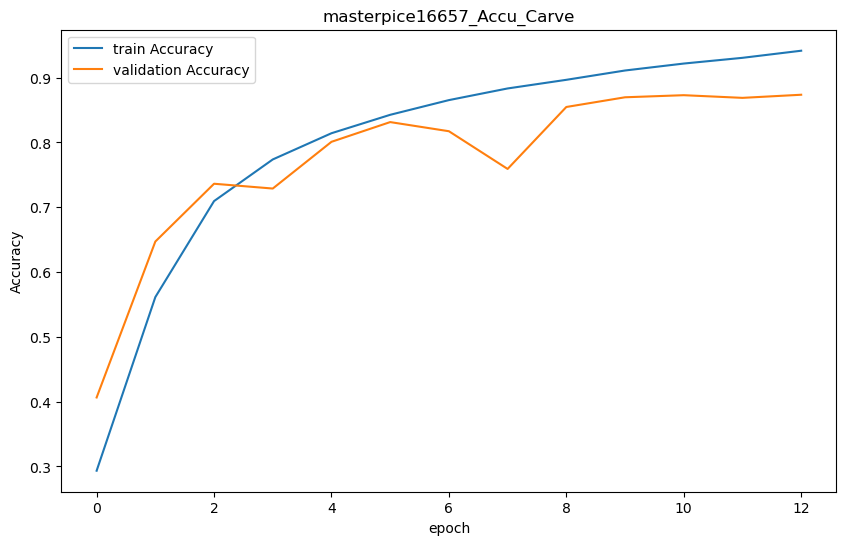

In [51]:
PLot_Model_Results(history,
                   Title=f"{modelName}_Accu_Carve",
                   Acc= True,
                   Saving=True,
                   Path_save=f"Results/{modelName}" )

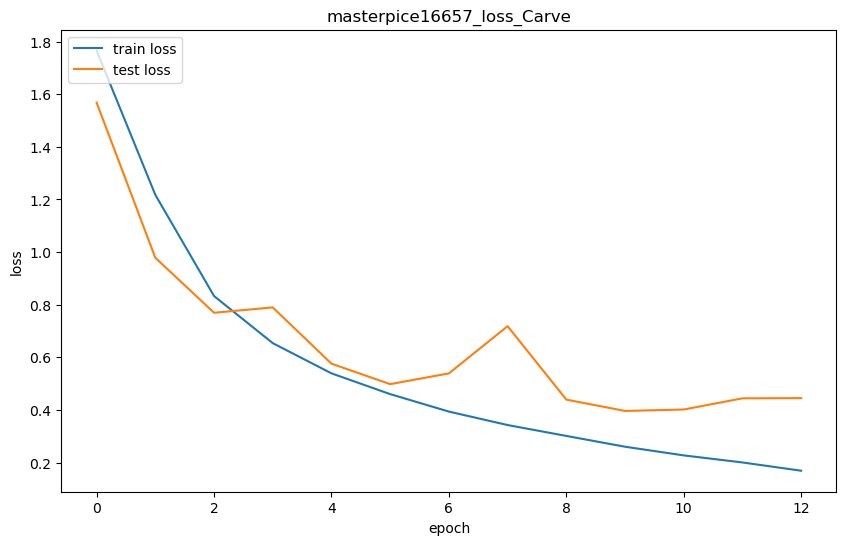

In [53]:
PLot_Model_Results(history,
                   Title=f"{modelName}_loss_Carve",
                   Acc= False,
                   Saving=True,
                   Path_save=f"Results/{modelName}" )

In [27]:
model.load_state_dict(torch.load(f"Results/masterpice16657/model/masterpice16657.pt"))
model.to('cuda')

RegNetX32(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv1d(0, 128, kernel_size=(9,), stride=(3,))
      (1): ReLU()
    )
    (stage1): Sequential(
      (0): conv1dblock(
        (conv): LazyConv1d(0, 128, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (1): conv1dblock(
        (conv): LazyConv1d(0, 128, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (2): conv1dblock(
        (conv): LazyConv1d(0, 256, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (3): conv1dblock(
        (conv): LazyConv1d(0, 256, kernel_size=(12,), stride=(1,))
        (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (4): conv1dblock(
        (conv): LazyConv1d(0, 512, kerne

In [28]:
# gih = pd.read_csv("test2.csv",converters={'a': pd.eval})

In [29]:
import sys
sys.path.append("../Error_anaysis_f")  
from Error_Analsis import Error_anaylsis

In [91]:
def Error__anaylsis(model, data_loader):

    # Calcaulte predicted
    preidcted = np.array([])
    true_labels = np.array([])

    with torch.no_grad():
        model.eval()
        test_acc = 0
        for images, labels in data_loader:
            outputs = model(images.to(device))
            _, pred = torch.max(outputs, dim=1)
            preidcted = np.append(preidcted, pred.to("cpu").numpy())
            true_labels = np.append(true_labels, labels.to("cpu").numpy())
            

            

    # Get the True labels, and files names
    indices = data_loader.dataset
    
    Labels_and_paths = np.array(data_loader.dataset.dataset.metadata.filename)[:]
    # img_paths = Labels_and_paths[:, 0]
    # true_labels = Labels_and_paths[:, 1].astype("int")

    # Get classes

    return preidcted, true_labels,Labels_and_paths

In [92]:
le = preprocessing.LabelEncoder()
df=pd.read_csv("../YTData.csv")
df.loc[:,'language']=le.fit_transform(df.loc[:,'language'])
df.to_csv("YTData2.csv", index=False)

In [93]:
dataset_Youtube=Language_detection('YTData2.csv','YouTube/clips',mel_spectrogram,divse(),samplerate,num_samples)
Youtube_test_dataset = Subset(dataset_Youtube, [i for i in range(0,700)])
Youtube_loader = torch.utils.data.DataLoader(Youtube_test_dataset, batch_size=128, shuffle=False, num_workers=20 * 4, pin_memory=True)


Using device cuda


In [94]:
preidcted, true_labels ,img_paths= Error__anaylsis(model, Youtube_loader)

In [95]:
len(true_labels)

700

In [62]:
class_= np.unique(Youtube_loader.dataset.dataset.metadata.language)

In [100]:
lites=[]
for i in class_ :
    lites.append((i,*le.inverse_transform([i])))
print(lites)

[(0, 'ar'), (1, 'de'), (2, 'en'), (3, 'es'), (4, 'fr'), (5, 'it'), (6, 'pt')]


In [101]:
modelName='conv1d on signal data'

In [102]:
lites = [x for _,x in lites] 
lites

['ar', 'de', 'en', 'es', 'fr', 'it', 'pt']

In [113]:
img_names = [x.lower() for x in img_paths.tolist()]

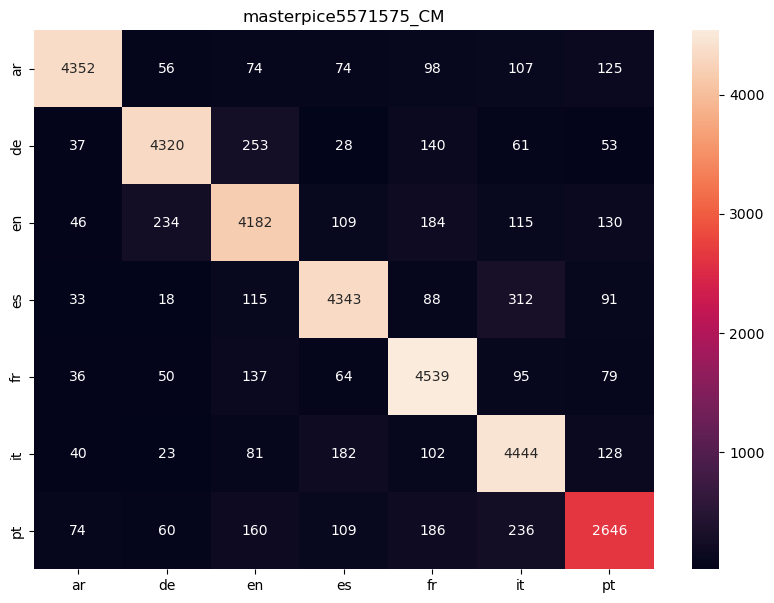

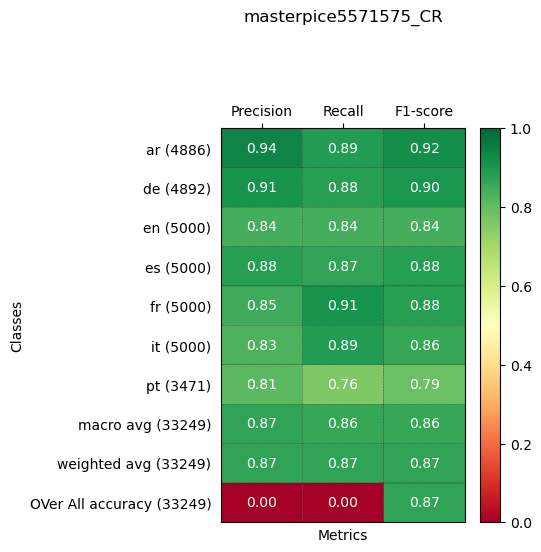

In [ ]:
EA =Error_anaylsis(
    true_labels,
    preidcted,
    lites,
    PathToSavePLots = f"Results/masterpice16657"
)
EA.CM(plotTitle=f"{modelName}_CM", Saving=True)
EA.CR(plotTitle=f"{modelName}_CR",printing=False, ploting=True, Saving=True)



In [ ]:
from IPython.display import FileLink
import shutil

shutil.make_archive(modelName, 'zip', modelName)
FileLink(f"{modelName}.zip")


In [ ]:
FileLink(f"Models.csv")

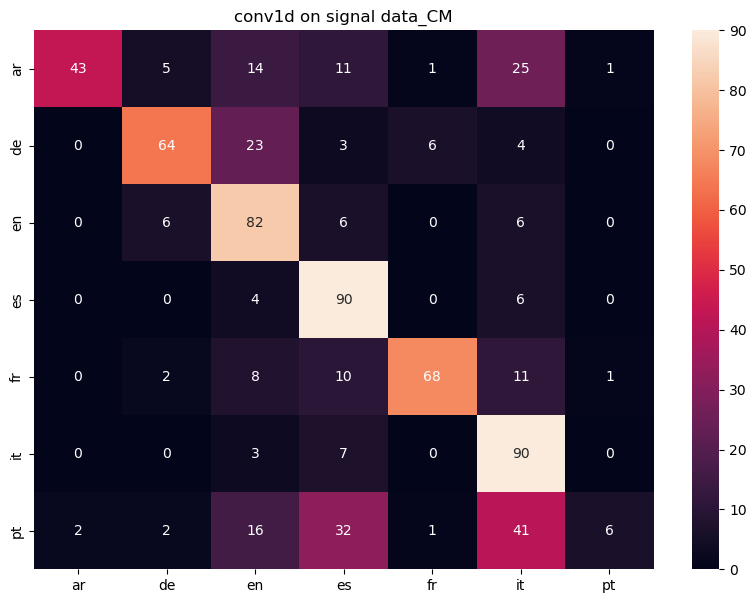

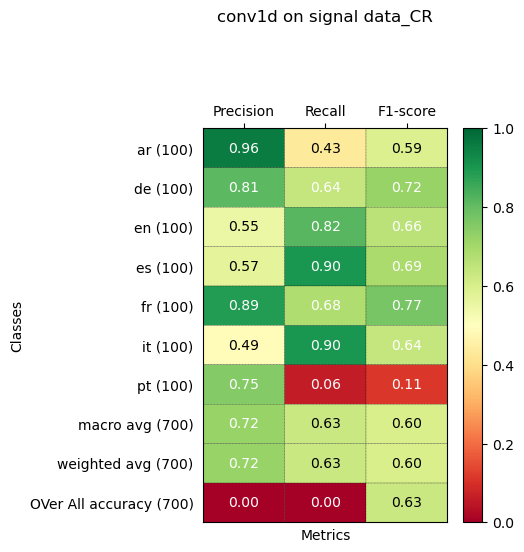

  Gender  values             type
0      f     404             Test
1      m     296             Test
0      f     179  False Predicted
1      m      78  False Predicted


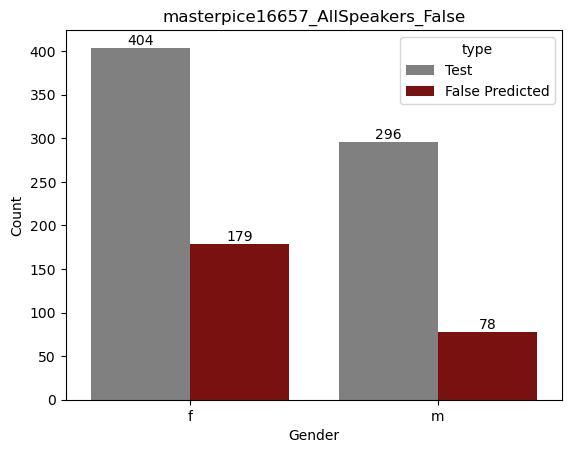

In [114]:
EA =Error_anaylsis(
    true_labels,
    preidcted,
    lites,
    PathToSavePLots = f"Results/masterpice16657",
    Df_Path="../Mel_Spectogram/YT_lower.csv",
    file_names=img_names,
)
EA.CM(plotTitle=f"{modelName}_CM", Saving=True)
EA.CR(plotTitle=f"{modelName}_CR",printing=False, ploting=True, Saving=True)


EA.All_Gender_disPlot(PLotTorF=0,  plotTitle=f"masterpice16657_AllSpeakers_False", saveing=True, Train=False, Gander= ['m', 'f'])



In [56]:
preidcted, true_labels = Error__anaylsis(model, test_dataset)

In [53]:
preidcted

array([3., 3., 2., 3., 3., 6., 3., 6., 3., 3., 3., 5., 6., 3., 5., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 4., 1., 3., 5., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 5., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3., 3., 3.,
       3., 3., 4., 3., 3., 3., 3., 6., 3., 0., 3., 5., 6., 3., 3., 3., 6.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 5., 3., 5., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 5., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 0., 3., 0., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 5., 5., 5., 3., 5., 3.])

In [54]:
true_labels

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [34]:
len(TESTmel)

33249

In [36]:
test_dataset = Subset(test_loader, [i for i in range(0,len(TESTmel))])


In [59]:
class_= np.unique(test_dataset.dataset.dataset.metadata.language)

In [60]:
lites=[]
for i in class_ :
    lites.append((i,*le.inverse_transform([i])))
print(lites)

[(0, 'ar'), (1, 'de'), (2, 'en'), (3, 'es'), (4, 'fr'), (5, 'it'), (6, 'pt')]


In [63]:
lites = [x for _,x in lites] 

In [64]:
lites

['ar', 'de', 'en', 'es', 'fr', 'it', 'pt']

In [ ]:
img_names = [x.split("/")[-1] for x in img_paths]
img_names = [x.split(".")[0] + ".wav" for x in img_names]

In [57]:
import sys
sys.path.append("../Error_anaysis_f")  
from Error_Analsis import Error_anaylsis

###############################################
##############################################

In [ ]:
# model.load_state_dict(torch.load("vgg16_Mel128_200_M_P12085_67915/model/vgg16_Mel128_200_M_P12085_67915.pt"))